# MeteoNet Forecasts

The challenge in this notebook is to **predict the temperatures** of a place in based on weather data from previous days.

For that, the dataset of the **Ground Stations** from *MeteoNet North-West France* available on Kaggle will be used.

This dataset includes a set of features recorded at 6-minute intervals for different weather stations in the North-West part of France.

# Imports

- **numpy** for linear algebra
- **pandas** to handle dataframes
- **matplotlib** for the displays
- **cartopy** for the base map display
- **geopy** for geodesic distances
- **datetime** to handle dates
- **sklear** for preprocessing, modeling, metrics...
- **tensorflow** for the neural network

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopy.distance

import datetime as dt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

# Quick Look

In [7]:
%%time
data0 = pd.read_csv('../input/meteonet/NW_Ground_Stations/NW_Ground_Stations/NW_Ground_Stations_2018.csv')

CPU times: user 23.1 s, sys: 4.99 s, total: 28.1 s
Wall time: 53.1 s


In [8]:
# Full dataset
data0

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.330,-0.430,2.0,20180101 00:00,240.0,8.2,0.0,84.0,276.75,279.25,NaN
1,14126001,49.150,0.040,125.0,20180101 00:00,NaN,NaN,0.0,98.0,278.75,279.05,NaN
2,14137001,49.180,-0.460,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
3,14216001,48.928,-0.149,155.0,20180101 00:00,240.0,5.4,0.0,77.0,276.45,280.25,NaN
4,14296001,48.790,-1.040,336.0,20180101 00:00,NaN,NaN,0.0,NaN,NaN,278.35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22034566,86137003,47.035,0.098,96.0,20181231 23:54,40.0,2.9,0.0,88.0,278.85,280.75,NaN
22034567,86165005,46.412,0.841,153.0,20181231 23:54,60.0,3.3,0.0,95.0,278.85,279.55,NaN
22034568,86272002,46.839,0.457,120.0,20181231 23:54,NaN,NaN,0.0,NaN,NaN,NaN,NaN
22034569,91200002,48.526,1.993,116.0,20181231 23:54,270.0,0.8,0.0,96.0,279.75,280.35,NaN


In [9]:
# Investigate the number of stations
print("The full dataset is composed of {} different and unique weather stations.".format(data0['number_sta'].nunique()))

The full dataset is composed of 271 different and unique weather stations.


In [10]:
# Investigate missing records
theoretical_nb_of_rows = 10 * 24 * 365 * 271 # 10 records per hour, 24 hours per day, 365 days in 2018, 271 stations
actual_nb_of_rows = data0.shape[0]
missing_records_ratio = 1 - (actual_nb_of_rows / theoretical_nb_of_rows)
print("Ratio of missing records: {:.1f}%".format(missing_records_ratio * 100))

Ratio of missing records: 7.2%


In [11]:
data0.isna().sum()

number_sta           0
lat                  0
lon                  0
height_sta           0
date                 0
dd             8605703
ff             8598613
precip         1279127
hu             8783452
td             8786154
t              2893694
psl           17621180
dtype: int64

The *Ground Stations* dataset is composed of **6-minute interval records** of meteorological parameters for **271 unique weather stations** in the North West of France **over a full year** (2018).

After a little exploration, I noticed a few points to pay attention to:
- Not all records were successfully saved in time. In other words, there are rows missing from this dataset. The ratio of missing records on average per station is 7.2%. This could be due to a power failure or other problem at the station location. To overcome this problem, we could then use the data of the nearest station for these missing lines.
- There are sometimes missing values for some weather parameters. I have seen that this sometimes happens for several continuous moments. Again it is probably due to a broken device or being stopped for a little while. We will impute these missing values using a k-nearest neighbors imputer.
- The dataset is quite big with more than 22 million rows for a single year data records. I will reduce the task to predictions for only one weather station at a time. It means that the model will only focus on local data pour the forecasts.

# Data Reduction to a Single Station

Let's create a function that takes in inputs the **dataset of the stations and the coordinates** we want.

The function will return the **id of the station** near the coordinates and its **row index** in the dataset of the stations.

Must be first created the dataset of the available stations and the associated coordinates.

It seems that for all the records of a given station number, the latitudes and longitudes sometimes slightly change. It's probably due to way they have been enter.

I take the mean of them for simplicity. Coordinates do not need to be very precise anyway.

In [12]:
# Dataset of unique stations
stations = data0[['number_sta', 'lat', 'lon']].groupby('number_sta', as_index=False).mean()
stations

,number_sta,lat,lon
0,14066001,49.333064,-0.430766
1,14126001,49.146191,0.041523
2,14137001,49.180000,-0.456935
3,14216001,48.928000,-0.149000
4,14296001,48.793821,-1.037707
...,...,...,...
266,86137003,47.035000,0.098000
267,86165005,46.412000,0.841000
268,86272002,46.839245,0.455285
269,91200002,48.526096,1.993192


The function calculates the geodesic distance between the chosen coordinate point and all the stations using geopy.

Then it returns the nth closest station from to the input coordinates. By default, it returns the closest one.

In [13]:
# Returns the nth closest station (from rank) next to the chosen coordinates
def get_closest_station(latitude, longitude, rank=1):
    
    # Calculate distance from each station (km)
    distances = []
    for i in range(len(stations)):
        coord1 = (LATITUDE, LONGITUDE)
        coord2 = (stations.loc[i, 'lat'], stations.loc[i, 'lon'])
        distances.append(geopy.distance.geodesic(coord1, coord2).km)
    station_distances = pd.concat([stations, pd.Series(distances, name='distance')], axis=1).sort_values(by='distance')
    
    station_id = int(station_distances.iloc[rank - 1]['number_sta'])
    station_lat = float(station_distances.iloc[rank - 1]['lat'])
    station_lon = float(station_distances.iloc[rank - 1]['lon'])
    station_dist = int(station_distances.iloc[rank - 1]['distance'])
    
    return station_id, station_lat, station_lon, station_dist

I want to make predictions for Brest. The geographical coordinates are around:
- Latitude: 48,50
- Longitude: -4.40

Now let's scatter all the northwestern French station over a base map.

The red cross is the chosen station. All these precautions will make it possible to change stations easily at the end and make forecasts at other places.

/opt/conda/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


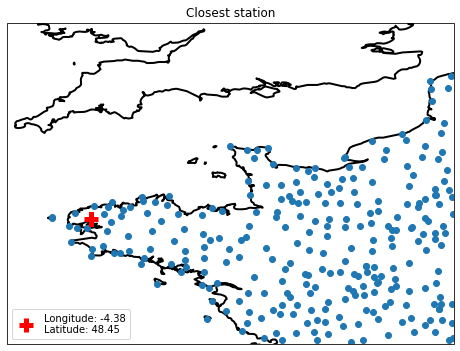

The closest station at has id 29075001.
Distance = 5 km


In [14]:
# Approximate coordinates of Brest (French City)
LATITUDE = 48.50
LONGITUDE = -4.40

# Get the closest station
station_id, station_lat, station_lon, station_dist = get_closest_station(LATITUDE, LONGITUDE)

# Display
plt.figure(figsize=(8, 6))

# Base map display
extent = [-5.85, 2.00, 46.25, 51.90] # low-left lon, up-right lon,  low-left lat, up-right lat
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=2)
ax.set_extent(extent)

# Data points display
plt.scatter(stations['lon'], stations['lat'])
plt.scatter(station_lon, station_lat, c='r', marker='+', s=200, linewidth=5,
            label="Longitude: {:.2f}\nLatitude: {:.2f}".format(station_lon, station_lat))

plt.title("Closest station")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower left')

plt.show()

print("The closest station at has id {}.\nDistance = {} km".format(station_id, station_dist))

> *Reference: Display of the base map inspired by Gwenn Lr, Lior Perez, Katerpillar and VChabot: https://www.kaggle.com/code/glarvor/open-ground-stations*

Now it is possible to reduce the dataset by only keeping the data from the chosen weather station. It will be lighter and easier to handle.

In [15]:
# Dataset of the weather station
data_station = data0[data0['number_sta'] == station_id].reset_index(drop=True)
data_station

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,29075001,48.45,-4.380,98.0,20180101 00:00,260.0,7.4,0.0,74.0,277.45,281.85,101020.0
1,29075001,48.45,-4.380,98.0,20180101 00:06,260.0,8.2,0.0,74.0,277.35,281.75,101020.0
2,29075001,48.45,-4.380,98.0,20180101 00:12,250.0,7.4,0.0,75.0,277.35,281.55,101010.0
3,29075001,48.45,-4.380,98.0,20180101 00:18,250.0,7.0,0.0,76.0,277.45,281.45,101010.0
4,29075001,48.45,-4.380,98.0,20180101 00:24,260.0,7.4,0.0,76.0,277.75,281.75,101010.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87465,29075001,48.45,-4.383,98.0,20181231 23:30,30.0,1.8,0.0,81.0,278.25,281.35,103790.0
87466,29075001,48.45,-4.383,98.0,20181231 23:36,30.0,1.4,0.0,82.0,278.35,281.25,103790.0
87467,29075001,48.45,-4.383,98.0,20181231 23:42,30.0,1.6,0.0,81.0,278.15,281.25,103800.0
87468,29075001,48.45,-4.383,98.0,20181231 23:48,30.0,1.9,0.0,80.0,278.15,281.35,103800.0


# Missing Records

As mentionned previously, there are missing records 

In [16]:
# Get missing records from to the closest station
def fill_in_missing_records(df):
    df = df.copy()
    
    full_time_range = pd.Series(pd.date_range(dt.datetime(2018, 1, 1, hour=0, minute=0), periods=87600, freq='6min'), name='date')

    r = 2
    while len(df) != 87600:
        
        # Datetimes
        current_times = df['date']
        missing_times = full_time_range[full_time_range.isin(current_times) == False]

        # Get the missing data
        new_id = get_closest_station(station_lat, station_lon, rank=r)[0]
        new_data_station = data0[data0['number_sta'] == new_id].reset_index(drop=True)
        missing_data = new_data_station[pd.to_datetime(new_data_station['date']).isin(missing_times)]

        # Concatenate
        df = pd.concat([df, missing_data], axis=0)
        
        r += 1

    df = df.sort_values(by='date').reset_index(drop=True)
    
    return df

In [17]:
data_station = fill_in_missing_records(data_station)
data_station

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,29075001,48.45,-4.380,98.0,20180101 00:00,260.0,7.4,0.0,74.0,277.45,281.85,101020.0
1,29075001,48.45,-4.380,98.0,20180101 00:06,260.0,8.2,0.0,74.0,277.35,281.75,101020.0
2,29075001,48.45,-4.380,98.0,20180101 00:12,250.0,7.4,0.0,75.0,277.35,281.55,101010.0
3,29075001,48.45,-4.380,98.0,20180101 00:18,250.0,7.0,0.0,76.0,277.45,281.45,101010.0
4,29075001,48.45,-4.380,98.0,20180101 00:24,260.0,7.4,0.0,76.0,277.75,281.75,101010.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87595,29075001,48.45,-4.383,98.0,20181231 23:30,30.0,1.8,0.0,81.0,278.25,281.35,103790.0
87596,29075001,48.45,-4.383,98.0,20181231 23:36,30.0,1.4,0.0,82.0,278.35,281.25,103790.0
87597,29075001,48.45,-4.383,98.0,20181231 23:42,30.0,1.6,0.0,81.0,278.15,281.25,103800.0
87598,29075001,48.45,-4.383,98.0,20181231 23:48,30.0,1.9,0.0,80.0,278.15,281.35,103800.0


# Datetime Downsampling

Now that we have at our disposal a dataset with all the records (missing values will be imputed later), we will reduce the number of records for our predictions.

The downsampling takes in parameters the starting hour of the day followed by the step as a positive number of days or a day fraction.

In [18]:
def datetime_downsampling(df, start_hour=0, day_step=1/4):
    
    keep_index = [x + 10 * start_hour for x in range(87600) if x % (240 * day_step) == 0]
    df = df.iloc[keep_index].reset_index(drop=True)
    
    return df

# Feature Engineering

## a - Datetimes

Now we can think about **feature engineering**. What are the cycles of temperature change in a year?

There are variations depending on the time of day but also a variable average during the seasons.

To represent this, we can define two features representing the recording number of the day *(from 1 to 240)* as well as the day number in the year *(from 1 to 365)*.

This range of values must be cyclical: the beginning is similar to the end, so we must apply a cyclic function.

- I used a cosine function with periods équal to the ranges 365 and 240.
- I also used an offset that matches the coldest times of the year and of the day, respectively around January 15th and every day around 5 a.m. (51st record).

The date processing function will be used in the main preprocessing function afterwards.

In [19]:
def datetime_processing(df):
    df = df.copy()
    
    df['date'] = pd.to_datetime(df['date'])
    df['day of year'] = df['date'].dt.day_of_year
    df['day record nb'] = (((df['date'].dt.minute + df['date'].dt.hour * 60) / 6) + 1).astype(int)
    
    # Apply cyclic function
    df['day of year'] = df['day of year'].map(lambda x: -np.cos(2 * np.pi / 365 * (x - 15)))
    df['day record nb'] = df['day record nb'].map(lambda x: -np.cos(2 * np.pi / 240 * (x - 51)))
    
    # Get rid of the date columns
    df = df.drop('date', axis=1)
    
    return df

## b - Wind direction

The wind direction goes from 0° to 360°. Obviously there is no difference between these two extrem values and this is why we must convert this data.

We cannot only apply a single cyclic function because we would not see the difference between one of the two pairs north/south or east/west. We have two solutions:
- Create categories of directions that refer to cardinal points (with one-hot encoding). However, this would not exploit all the information, nor the proximity between the directions.
- Express the feature as a two dimension feature (cos and sin) so the direction is represented by a point on a unite circle.

I choose the second option.

In [20]:
def wind_direction_processing(df):
    df = df.copy()
    
    # Map with cosine and sine functions
    df['wind dir cos'] = df['dd'].map(lambda x: np.cos(x))
    df['wind dir sin'] = df['dd'].map(lambda x: np.sin(x))
    
    # Get rid of previous wind direction column
    df = df.drop('dd', axis=1)
    
    return df

# Extract X and y

The data are all in a single dataframe and we need to extract the inputs from the targets.

The X set will contain the parameters of a series of days while the y set will contain the temperatures for the next days.

A window is defined for both X and y corresponding to the number of records to keep.

In [234]:
def extract_X_y(df, X_window, y_window):
    df = df.copy()
    
    X, y = [], []
    
    # Loop over the whole dataframe
    for i in range(len(df) - X_window - y_window):
        X.append(np.array(df.iloc[i : i + X_window]).flatten())
        y.append(np.array(pd.DataFrame(df['t'][i + X_window : i + X_window + y_window])).flatten())
    
    X = np.array(X).reshape(*np.array(X).shape, 1)
    y = np.array(y).reshape(*np.array(y).shape, 1)
  
    return X, y

# Main Preprocessing

The next step is to **clean up the dataframe** by removing unnecessary columns, filling in missing values, and preprocessing data for the model.

Let's create a function that will do these steps:
- Use the previous function to convert data from the datetime
- Drop the unnecessary columns, constant columns
- Fill in missing values with a KNN approach
- Convert data to numerical

In [172]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop unnecessary columns
    df = df.drop(['number_sta', 'lat', 'lon', 'height_sta'], axis=1)
    
    # Datetime processing
    df = datetime_processing(df)
    
    # Wind direction processing
    df = wind_direction_processing(df)
    
    # KNN imputation
    imputer = KNNImputer(n_neighbors=5) # default
    df_numeric = df.select_dtypes(np.number)
    df_object = df.drop(df_numeric.columns, axis=1)
    df_numeric = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
    df = pd.concat([df_object, df_numeric], axis=1)
    
    # Datetime downsampling
    df = datetime_downsampling(df, start_hour=0, day_step=DAY_STEP)
    
    # Scale data
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    # Extract X and y
    X, y = extract_X_y(df, X_window=X_WINDOW, y_window=Y_WINDOW)
    
    return X, y

In [235]:
X_WINDOW = 20
Y_WINDOW = 5
DAY_STEP = 1/4

X, y = preprocess_inputs(data_station)

# Model

In [241]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(X_WINDOW, input_shape=X.shape[-2:]),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(Y_WINDOW)
])

lstm_model.compile(optimizer='adam', metrics=['mae'], loss='mse')
lstm_model.fit(X, y, epochs=200)

Epoch 1/200
45/45 [==============================] - 5s 54ms/step - loss: 0.7263 - mae: 0.6612
Epoch 2/200
45/45 [==============================] - 2s 52ms/step - loss: 0.4953 - mae: 0.5457
Epoch 3/200
45/45 [==============================] - 2s 55ms/step - loss: 0.4776 - mae: 0.5361
Epoch 4/200
45/45 [==============================] - 2s 53ms/step - loss: 0.4624 - mae: 0.5250
Epoch 5/200
45/45 [==============================] - 2s 54ms/step - loss: 0.4593 - mae: 0.5227
Epoch 6/200
45/45 [==============================] - 2s 54ms/step - loss: 0.4429 - mae: 0.5130
Epoch 7/200
45/45 [==============================] - 2s 55ms/step - loss: 0.4395 - mae: 0.5111
Epoch 8/200
45/45 [==============================] - 3s 60ms/step - loss: 0.4303 - mae: 0.5050
Epoch 9/200
45/45 [==============================] - 2s 56ms/step - loss: 0.4170 - mae: 0.5000
Epoch 10/200
45/45 [==============================] - 3s 57ms/step - loss: 0.4161 - mae: 0.4994
Epoch 11/200
45/45 [=============================

In [246]:
X_test = X[1000:1020, :, :]
y_test = y[1000:1020, :, :]

In [249]:
y_pred = lstm_model.predict(X_test)